In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Reading Function

def imread_rgb(path):
    """Read an image in RGB, float32 [0,1]."""
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0

def imsave_rgb(path, img):
    """Save an RGB float image back to disk."""
    bgr = cv2.cvtColor((np.clip(img,0,1)*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, bgr)
    

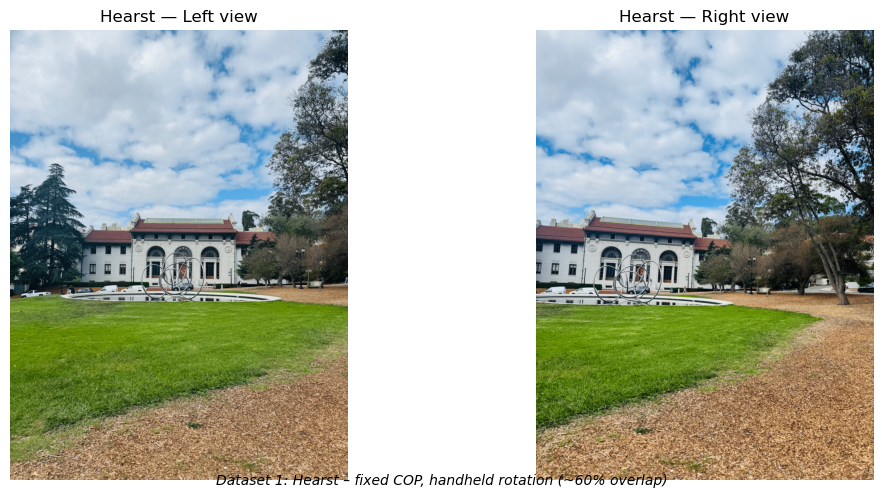

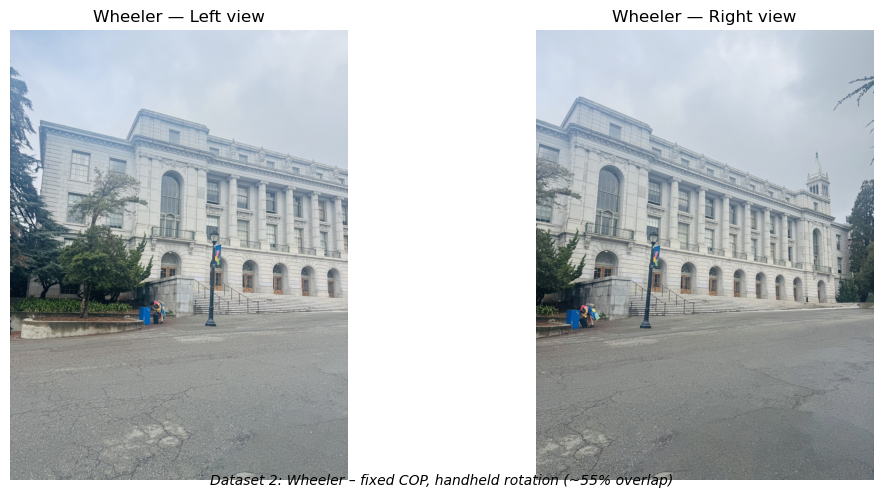

In [3]:
# ==== A.1 — Shoot the Pictures (display + save, with subtitle) ==============
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

def imread_rgb(path):
    """Read an image as RGB float32 in [0,1]."""
    bgr = cv2.imread(str(path), cv2.IMREAD_COLOR)
    assert bgr is not None, f"File not found: {path}"
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    return rgb

# Update these paths if yours differ
p_hearst_left  = Path("assets/imgs/hearst_left.png")
p_hearst_right = Path("assets/imgs/hearst_right.png")
p_wheeler_left  = Path("assets/imgs/left_a1.png")    # your Wheeler left
p_wheeler_right = Path("assets/imgs/right_a1.png")   # your Wheeler right

hearst_left   = imread_rgb(p_hearst_left)
hearst_right  = imread_rgb(p_hearst_right)
wheeler_left  = imread_rgb(p_wheeler_left)
wheeler_right = imread_rgb(p_wheeler_right)

def show_pair(imL, imR, titleL, titleR, subtitle):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(imL); plt.title(titleL); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(imR); plt.title(titleR); plt.axis('off')
    plt.figtext(0.5, 0.02, subtitle, wrap=True, ha='center', fontsize=10, style='italic')
    plt.tight_layout()
    return plt.gcf()

# Pair 1: Hearst (handheld rotation, ~50–70% overlap)
fig1 = show_pair(hearst_left, hearst_right,
                 "Hearst — Left view",
                 "Hearst — Right view",
                 "Dataset 1: Hearst – fixed COP, handheld rotation (~60% overlap)")

# Pair 2: Wheeler (handheld rotation, ~50–70% overlap)
fig2 = show_pair(wheeler_left, wheeler_right,
                 "Wheeler — Left view",
                 "Wheeler — Right view",
                 "Dataset 2: Wheeler – fixed COP, handheld rotation (~55% overlap)")

# Save figures for the report
outdir = Path("assets/imgs"); outdir.mkdir(parents=True, exist_ok=True)
fig1.savefig(outdir/"A1_hearst_pair.png", dpi=150, bbox_inches="tight")
fig2.savefig(outdir/"A1_wheeler_pair.png", dpi=150, bbox_inches="tight")
plt.show()



A.2 — HOMOGRAPHY RESULTS

Wheeler H (right->left):
[[ 8.87620537e-03 -3.32282383e-01  9.71807149e+02]
 [ 1.03858978e-01 -5.57934058e-01  1.41904479e+03]
 [ 1.87332405e-05 -3.34341285e-04  1.00000000e+00]]

Hearst H (right->left):
[[ 6.81423228e-01  6.72498346e-02  9.10693625e+02]
 [-2.71504693e-01  9.11515605e-01  3.49370082e+02]
 [-7.88317452e-05  7.31475620e-06  1.00000000e+00]]


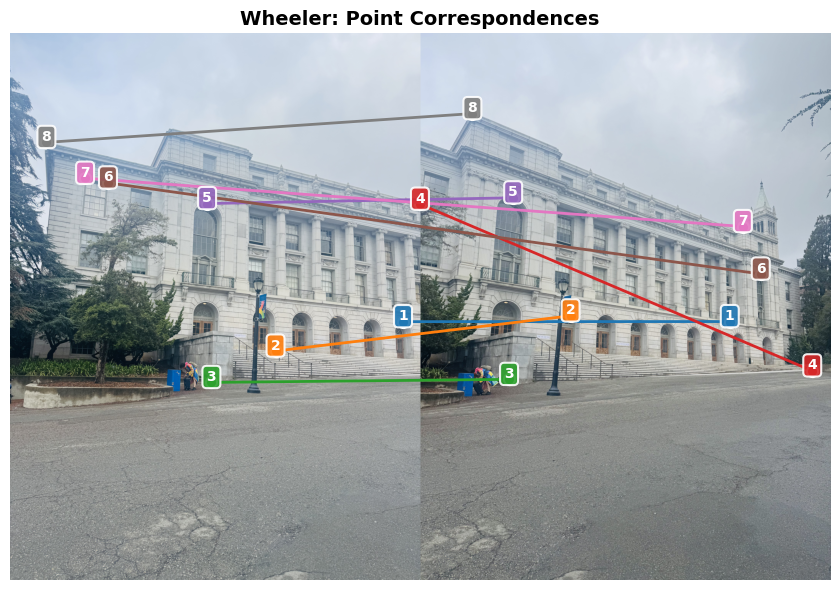

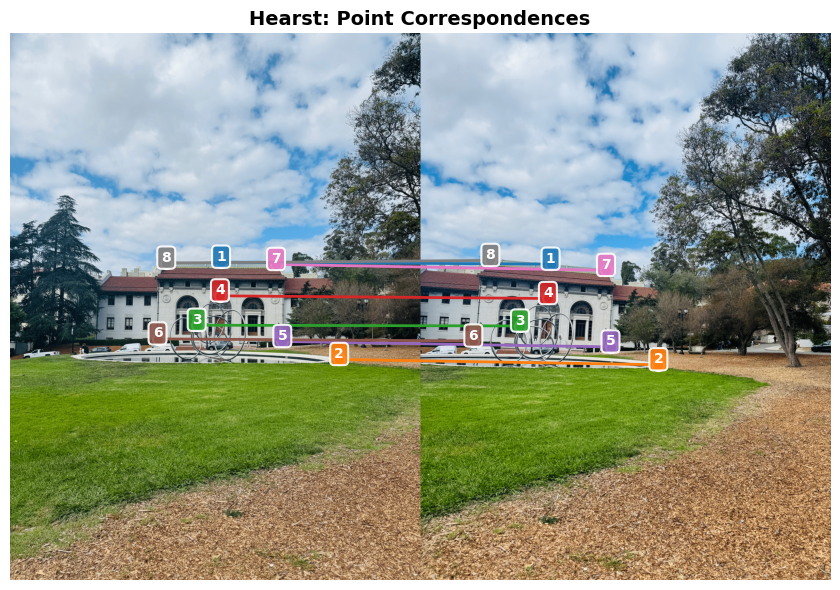

In [7]:
# ==== A.2 — Recover Homographies ==============
wL = np.array([
    [4106, 3012], 
    [2774, 3319], 
    [2104, 3647], 
    [4283, 1784],
    [2059, 1778], 
    [1023, 1562], 
    [ 784, 1513], 
    [ 380, 1139]
], float)
wR = np.array([
    [3236, 3011], 
    [1573, 2951],  
    [930, 3615],
    [4098, 3526], 
    [ 973, 1718],
    [3560, 2514],
    [3373, 2018], 
    [ 547,  838]
], float)
hL = np.array([
    [2205, 2390], 
    [3439, 3407], 
    [1950, 3049],
    [2193, 2742],
    [2845, 3219], 
    [1541, 3192], 
    [2779, 2414], 
    [1632, 2400]
], float)
hR = np.array([
    [1364, 2411], 
    [2490, 3462], 
    [1044, 3057], 
    [1336, 2770],
    [1990, 3276], 
    [ 557, 3214], 
    [1943, 2476], 
    [ 735, 2372]
], float)

def computeH(im1_points, im2_points):
    n = im1_points.shape[0]
    A = np.zeros((2*n, 8))
    b = np.zeros((2*n, 1))
    
    for i in range(n):
        x, y = im1_points[i]
        xp, yp = im2_points[i]
        A[2*i] = [x, y, 1, 0, 0, 0, -x*xp, -y*xp]
        b[2*i] = xp
        A[2*i+1] = [0, 0, 0, x, y, 1, -x*yp, -y*yp]
        b[2*i+1] = yp
    
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.vstack([h, [[1]]]).reshape(3, 3)
    return H

def viz_correspondences(imL, imR, ptsL, ptsR, title):
    h_L, w_L = imL.shape[:2]
    h_R, w_R = imR.shape[:2]
    h = max(h_L, h_R)
    canvas = np.hstack([np.pad(imL, ((0,h-h_L),(0,0),(0,0))) if h_L<h else imL,
                        np.pad(imR, ((0,h-h_R),(0,0),(0,0))) if h_R<h else imR])
    
    plt.figure(figsize=(16, 6))
    plt.imshow(canvas)
    plt.title(title, fontsize=14, weight='bold')
    plt.axis('off')
    
    for i in range(len(ptsL)):
        color = plt.cm.tab10(i % 10)
        plt.plot([ptsL[i,0], ptsR[i,0]+w_L], [ptsL[i,1], ptsR[i,1]], 
                'o-', color=color, linewidth=2, markersize=8, markeredgecolor='white', markeredgewidth=1.5)
        plt.text(ptsL[i,0], ptsL[i,1]-15, str(i+1), color='white', fontsize=10, weight='bold', ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.9, edgecolor='white', linewidth=1.5))
        plt.text(ptsR[i,0]+w_L, ptsR[i,1]-15, str(i+1), color='white', fontsize=10, weight='bold', ha='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.9, edgecolor='white', linewidth=1.5))
    plt.tight_layout()
    return plt.gcf()

# Compute homographies
H_wheeler = computeH(wR, wL)
H_hearst = computeH(hR, hL)

# Visualize
fig_w = viz_correspondences(wheeler_left, wheeler_right, wL, wR, "Wheeler: Point Correspondences")
fig_w.savefig(outdir/"A2_wheeler_correspondences.png", dpi=150, bbox_inches="tight")

fig_h = viz_correspondences(hearst_left, hearst_right, hL, hR, "Hearst: Point Correspondences")
fig_h.savefig(outdir/"A2_hearst_correspondences.png", dpi=150, bbox_inches="tight")

# Print results
print("\n" + "="*60)
print("A.2 — HOMOGRAPHY RESULTS")
print("="*60)
print("\nWheeler H (right->left):")
print(H_wheeler)
print("\nHearst H (right->left):")
print(H_hearst)

plt.show()


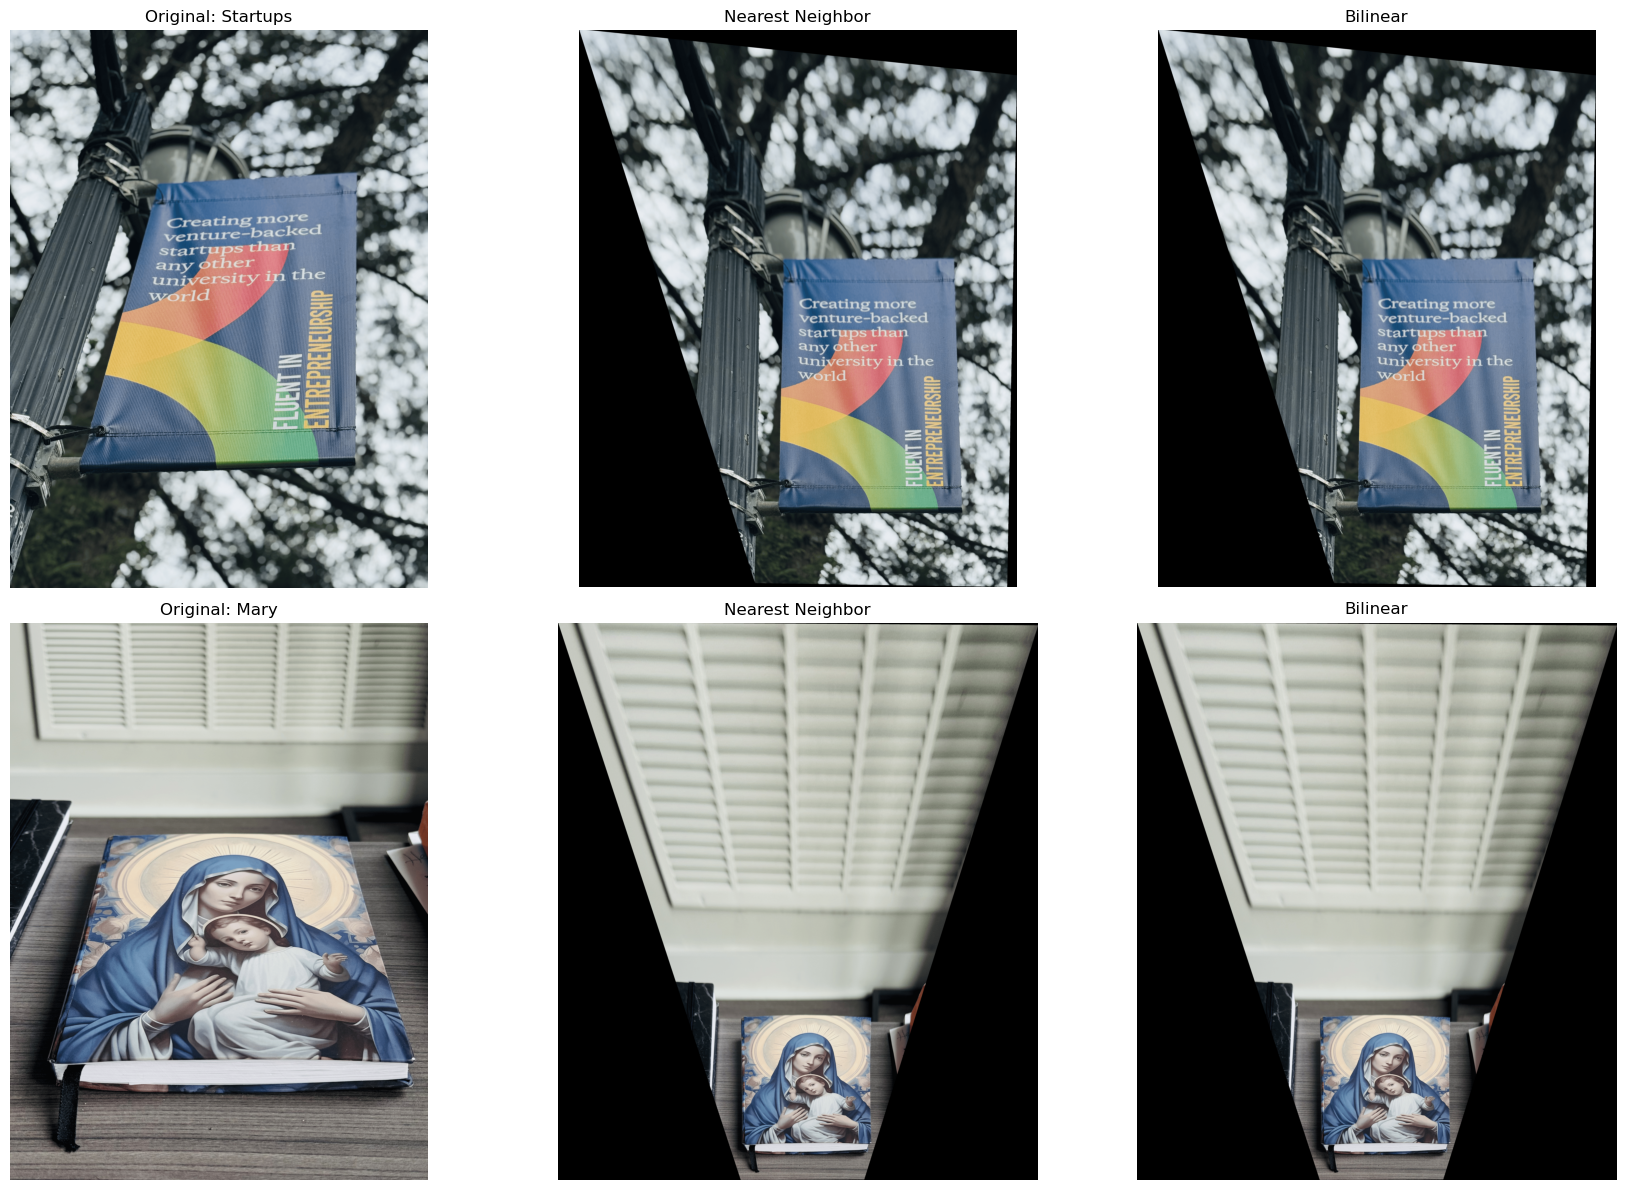

In [5]:
# ==== A.3 — Warp the Images ==============

p_startups = Path("assets/imgs/startups.png")
p_mmary = Path("assets/imgs/MMary.png")
startups = imread_rgb(p_startups)
mmary = imread_rgb(p_mmary)

startups_pts = np.array([[1080,1114], [2566,1034], [2483,3088], [566,3142]], float)
mary_pts = np.array([[724,1551], [2435,1552], [2923,3160], [281,3151]], float)

def warpImageNearestNeighbor(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0,0], [w-1,0], [w-1,h-1], [0,h-1]], float)
    corners_hom = np.hstack([corners, np.ones((4,1))])
    corners_w = (H @ corners_hom.T).T
    corners_w = corners_w[:,:2] / corners_w[:,2:3]
    
    x_min, y_min = np.floor(corners_w.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(corners_w.max(axis=0)).astype(int)
    out_h, out_w = y_max-y_min, x_max-x_min
    
    # Vectorized grid
    yy, xx = np.meshgrid(np.arange(out_h), np.arange(out_w), indexing='ij')
    xx_dst = xx + x_min
    yy_dst = yy + y_min
    pts = np.stack([xx_dst.ravel(), yy_dst.ravel(), np.ones(xx_dst.size)], axis=0)
    
    H_inv = np.linalg.inv(H)
    pts_src = H_inv @ pts
    xx_src = (pts_src[0] / pts_src[2]).reshape(out_h, out_w)
    yy_src = (pts_src[1] / pts_src[2]).reshape(out_h, out_w)
    
    xx_near = np.round(xx_src).astype(int)
    yy_near = np.round(yy_src).astype(int)
    valid = (xx_near >= 0) & (xx_near < w) & (yy_near >= 0) & (yy_near < h)
    
    out = np.zeros((out_h, out_w, 3), float) if im.ndim == 3 else np.zeros((out_h, out_w), float)
    if im.ndim == 3:
        for c in range(3):
            out[valid, c] = im[yy_near[valid], xx_near[valid], c]
    else:
        out[valid] = im[yy_near[valid], xx_near[valid]]
    return out

def warpImageBilinear(im, H):
    h, w = im.shape[:2]
    corners = np.array([[0,0], [w-1,0], [w-1,h-1], [0,h-1]], float)
    corners_hom = np.hstack([corners, np.ones((4,1))])
    corners_w = (H @ corners_hom.T).T
    corners_w = corners_w[:,:2] / corners_w[:,2:3]
    
    x_min, y_min = np.floor(corners_w.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(corners_w.max(axis=0)).astype(int)
    out_h, out_w = y_max-y_min, x_max-x_min
    
    yy, xx = np.meshgrid(np.arange(out_h), np.arange(out_w), indexing='ij')
    pts = np.stack([(xx+x_min).ravel(), (yy+y_min).ravel(), np.ones(xx.size)], axis=0)
    
    H_inv = np.linalg.inv(H)
    pts_src = H_inv @ pts
    xx_src = (pts_src[0] / pts_src[2]).reshape(out_h, out_w)
    yy_src = (pts_src[1] / pts_src[2]).reshape(out_h, out_w)
    
    x0 = np.floor(xx_src).astype(int)
    y0 = np.floor(yy_src).astype(int)
    x1, y1 = x0 + 1, y0 + 1
    wx, wy = xx_src - x0, yy_src - y0
    
    valid = (x0>=0) & (x1<w) & (y0>=0) & (y1<h)
    out = np.zeros((out_h, out_w, 3), float)
    
    for c in range(3):
        out[valid, c] = (im[y0[valid], x0[valid], c] * (1-wx[valid]) * (1-wy[valid]) +
                         im[y0[valid], x1[valid], c] * wx[valid] * (1-wy[valid]) +
                         im[y1[valid], x0[valid], c] * (1-wx[valid]) * wy[valid] +
                         im[y1[valid], x1[valid], c] * wx[valid] * wy[valid])
    return out

# Rectify
w_rect = int(np.linalg.norm(startups_pts[1] - startups_pts[0]))
h_rect = int(np.linalg.norm(startups_pts[3] - startups_pts[0]))
rect_dst = np.array([[0,0], [w_rect,0], [w_rect,h_rect], [0,h_rect]], float)

H_startups = computeH(startups_pts, rect_dst)
startups_nn = warpImageNearestNeighbor(startups, H_startups)
startups_bil = warpImageBilinear(startups, H_startups)

w_rect2 = int(np.linalg.norm(mary_pts[1] - mary_pts[0]))
h_rect2 = int(np.linalg.norm(mary_pts[3] - mary_pts[0]))
rect_dst2 = np.array([[0,0], [w_rect2,0], [w_rect2,h_rect2], [0,h_rect2]], float)

H_mary = computeH(mary_pts, rect_dst2)
mary_nn = warpImageNearestNeighbor(mmary, H_mary)
mary_bil = warpImageBilinear(mmary, H_mary)

# Display
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes[0,0].imshow(startups); axes[0,0].set_title('Original: Startups'); axes[0,0].axis('off')
axes[0,1].imshow(startups_nn); axes[0,1].set_title('Nearest Neighbor'); axes[0,1].axis('off')
axes[0,2].imshow(startups_bil); axes[0,2].set_title('Bilinear'); axes[0,2].axis('off')
axes[1,0].imshow(mmary); axes[1,0].set_title('Original: Mary'); axes[1,0].axis('off')
axes[1,1].imshow(mary_nn); axes[1,1].set_title('Nearest Neighbor'); axes[1,1].axis('off')
axes[1,2].imshow(mary_bil); axes[1,2].set_title('Bilinear'); axes[1,2].axis('off')
plt.tight_layout()
plt.savefig(outdir/"A3_rectification_comparison.png", dpi=150, bbox_inches="tight")
plt.show()


Creating mosaics... (this may take a minute)
Mosaic 1: Wheeler...
Mosaic 2: Hearst...
Mosaic 3: Hallway...


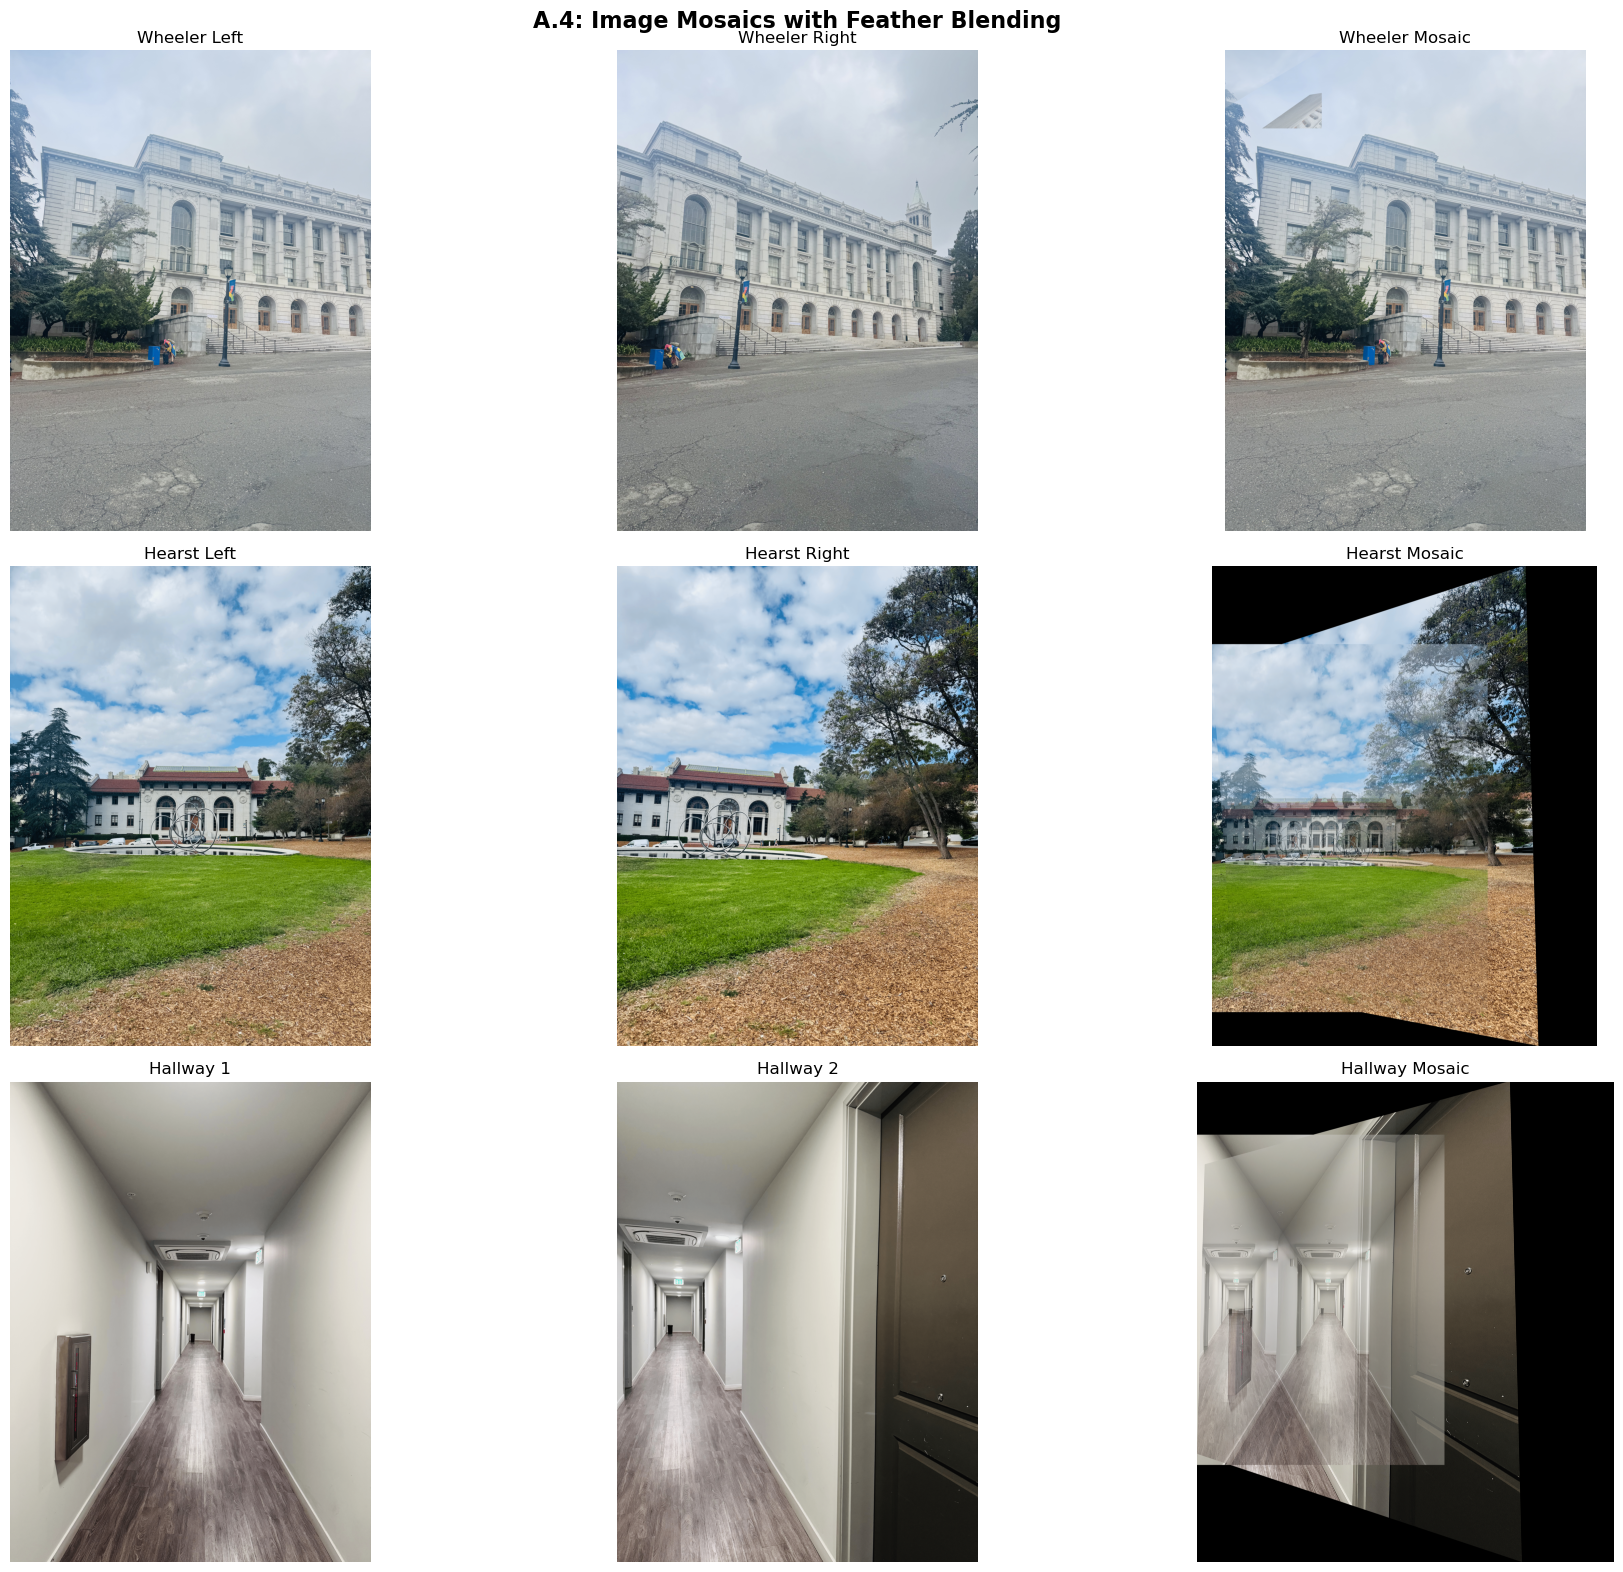


A.4 COMPLETE!

Blending Method: Feather blending using distance-based alpha masks
- Left image stays in original position (reference frame)
- Right image warped using computed homography
- Alpha masks created using distance transform
- Weighted averaging in overlap regions reduces seams

Saved: assets/imgs/A4_mosaics.png


In [8]:
# ==== A.4 — Blend the Images into a Mosaic ==============

p_hall1 = Path("assets/imgs/hallway1.png")
p_hall2 = Path("assets/imgs/hallway2.png")
hallway1 = imread_rgb(p_hall1)
hallway2 = imread_rgb(p_hall2)

hall1 = np.array([
    [2767, 3794],
    [1722, 3793],
    [3019, 1821],
    [1708, 1890],
    [2379, 3087],
    [2130, 3083],
    [2390, 2686],
    [2133, 2678],
], dtype=float)

hall2 = np.array([
    [1275, 3674],
    [  87, 3783],
    [1489, 1690],
    [  16, 1632],
    [ 876, 2980],
    [ 589, 2982],
    [ 881, 2557],
    [ 584, 2545],
], dtype=float)

def create_alpha_mask(shape):
    """
    Create distance-based alpha mask.
    Alpha = 1 at center, falls off to 0 at edges.
    """
    h, w = shape[:2]
    
    # Create binary mask (all ones for now)
    mask = np.ones((h, w), dtype=np.uint8)
    
    # Compute distance transform
    dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
    
    # Normalize to [0, 1]
    if dist.max() > 0:
        alpha = dist / dist.max()
    else:
        alpha = mask.astype(np.float32)
    
    return alpha

def create_mosaic(img_left, img_right, H_right_to_left):
    """
    Simple mosaic: left stays fixed, warp right into left's frame.
    """
    h_left, w_left = img_left.shape[:2]
    
    # Warp right image using your existing function
    warped_right = warpImageBilinear(img_right, H_right_to_left)
    
    # Get bbox of warped image
    h_right, w_right = img_right.shape[:2]
    corners = np.array([[0, 0], [w_right-1, 0], 
                        [w_right-1, h_right-1], [0, h_right-1]], dtype=float)
    corners_hom = np.hstack([corners, np.ones((4, 1))])
    corners_warped = (H_right_to_left @ corners_hom.T).T
    corners_warped = corners_warped[:, :2] / corners_warped[:, 2:3]
    
    x_min = int(np.floor(min(0, corners_warped[:, 0].min())))
    y_min = int(np.floor(min(0, corners_warped[:, 1].min())))
    x_max = int(np.ceil(max(w_left, corners_warped[:, 0].max())))
    y_max = int(np.ceil(max(h_left, corners_warped[:, 1].max())))
    
    # Create canvas
    canvas_w = x_max - x_min
    canvas_h = y_max - y_min
    canvas = np.zeros((canvas_h, canvas_w, 3), dtype=np.float32)
    
    # Calculate offsets
    offset_x = -x_min
    offset_y = -y_min
    
    # Place left image (unwarped)
    canvas[offset_y:offset_y+h_left, offset_x:offset_x+w_left] = img_left
    
    # Place warped right image with simple averaging in overlap
    h_warp, w_warp = warped_right.shape[:2]
    
    # Figure out where warped_right goes on canvas
    # warped_right's (0,0) corresponds to (x_min, y_min) in original coords
    right_y0 = y_min + offset_y
    right_x0 = x_min + offset_x
    right_y1 = right_y0 + h_warp
    right_x1 = right_x0 + w_warp
    
    # Ensure bounds
    right_y0 = max(0, right_y0)
    right_x0 = max(0, right_x0)
    right_y1 = min(canvas_h, right_y1)
    right_x1 = min(canvas_w, right_x1)
    
    # Extract corresponding region from warped
    wy0 = 0 if right_y0 >= 0 else -right_y0
    wx0 = 0 if right_x0 >= 0 else -right_x0
    wy1 = wy0 + (right_y1 - right_y0)
    wx1 = wx0 + (right_x1 - right_x0)
    
    # Simple feather: average where both exist, use one where only one exists
    region_canvas = canvas[right_y0:right_y1, right_x0:right_x1]
    region_warped = warped_right[wy0:wy1, wx0:wx1]
    
    # Mask: where warped has content
    mask_warped = (region_warped.sum(axis=2) > 0).astype(float)
    mask_canvas = (region_canvas.sum(axis=2) > 0).astype(float)
    
    # Blend
    for c in range(3):
        canvas[right_y0:right_y1, right_x0:right_x1, c] = np.where(
            (mask_warped > 0) & (mask_canvas > 0),
            (region_canvas[:,:,c] + region_warped[:,:,c]) / 2,  # Average overlap
            np.where(mask_warped > 0, region_warped[:,:,c], region_canvas[:,:,c])
        )
    
    return canvas

# Compute homographies
H_wheeler = computeH(wL, wR) # changed from R -> L
H_hearst = computeH(hR, hL)   # right -> left
H_hallway = computeH(hall2, hall1)  # hallway2 -> hallway1

# Create mosaics
print("Creating mosaics... (this may take a minute)")
print("Mosaic 1: Wheeler...")
mosaic_wheeler = create_mosaic(wheeler_left, wheeler_right, H_wheeler)

print("Mosaic 2: Hearst...")
mosaic_hearst = create_mosaic(hearst_left, hearst_right, H_hearst)

print("Mosaic 3: Hallway...")
mosaic_hallway = create_mosaic(hallway1, hallway2, H_hallway)

# Display results
fig, axes = plt.subplots(3, 3, figsize=(20, 16))

# Wheeler
axes[0,0].imshow(wheeler_left); axes[0,0].set_title('Wheeler Left'); axes[0,0].axis('off')
axes[0,1].imshow(wheeler_right); axes[0,1].set_title('Wheeler Right'); axes[0,1].axis('off')
axes[0,2].imshow(mosaic_wheeler); axes[0,2].set_title('Wheeler Mosaic'); axes[0,2].axis('off')

# Hearst
axes[1,0].imshow(hearst_left); axes[1,0].set_title('Hearst Left'); axes[1,0].axis('off')
axes[1,1].imshow(hearst_right); axes[1,1].set_title('Hearst Right'); axes[1,1].axis('off')
axes[1,2].imshow(mosaic_hearst); axes[1,2].set_title('Hearst Mosaic'); axes[1,2].axis('off')

# Hallway
axes[2,0].imshow(hallway1); axes[2,0].set_title('Hallway 1'); axes[2,0].axis('off')
axes[2,1].imshow(hallway2); axes[2,1].set_title('Hallway 2'); axes[2,1].axis('off')
axes[2,2].imshow(mosaic_hallway); axes[2,2].set_title('Hallway Mosaic'); axes[2,2].axis('off')

plt.suptitle('A.4: Image Mosaics with Feather Blending', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(outdir/"A4_mosaics.png", dpi=150, bbox_inches="tight")
plt.show()
